In [3]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from scipy.sparse import diags
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def sample_J_normal(L, sigma, seed=None):
    """
    Draw couplings J_i = 1 + N(0, sigma^2), length L-1.
    J can be negative; no rejection.
    """
    rng = np.random.default_rng(seed)
    return 1.0 + sigma * rng.standard_normal(L - 1)

def sample_J_discrete(L, c, p):
    return np.random.choice(c, L, p)

def critical_h_from_J(J, tiny=1e-300):
    """
    h_c = exp( (1/(L-1)) * sum_k ln |J_k| ).
    Use absolute value to allow J_k < 0; protect J_k=0 by tiny.
    """
    absJ = np.abs(J)
    absJ = np.where(absJ == 0.0, tiny, absJ)
    return float(np.exp(np.mean(np.log(absJ))))

def smallest_two_eps(J, h="geo_mean", method="eigen_tridiag", scale_M=2.0):
    """ 
    Compute eps1, eps2 at h = h_c(J) using one of two methods: 
    
    eigen_triag: can calculate large L, but precession is bounded 
    by 1e-8 (square root of mechine precision)
    svd_dense: time complexity O(L^3). cannot calculate large L (maximumly~5000). 
    can reach mechine precision 1e-15
    svd_sparse: can caculate large L but very slow.
    can reach mechine precision 1e-15
    """
    J = np.asarray(J, dtype=np.float128)
    L = J.size + 1
    if h == "geo_mean":
        h = critical_h_from_J(J)  # uses ln|J| as you wanted

    if method.lower() == "eigen_tridiag":
        d = np.empty(L, dtype=np.float128)
        d[0] = h*h
        d[1:] = h*h + J*J
        e = h * J
        w = eigh_tridiagonal(d, e, eigvals_only=True,
                             select="i", select_range=(0, 1),
                             check_finite=False)
        eps = np.sqrt(np.maximum(w, 0.0)) * scale_M
        return float(eps[0]), float(eps[1]), h

    elif method.lower() == "svd_sparse":
        # Build sparse bidiagonal M (lower bidiagonal: diag=h, subdiag=J)
        main = np.full(L, h, dtype=np.float128)
        M = diags([J, main], offsets=[-1, 0], shape=(L, L), format="csc")

        # PROPACK backend, smallest magnitude singular values
        # Note: order not guaranteed -> sort ascending
        s = svds(M,k=2,which="SM", solver='propack', tol=1e-10, maxiter=5000, return_singular_vectors=False)
        s = np.sort(s)  # ascending
        eps = s * scale_M
        return float(eps[0]), float(eps[1]), h
    
    elif method.lower() == "svd_dense":
        M = np.zeros((L, L), dtype=np.float128)
        np.fill_diagonal(M, h)
        M[np.arange(1, L), np.arange(0, L-1)] = J
        s = svd(M, compute_uv=False)
        s = np.sort(s)  # ascending
        eps = s * scale_M
        return float(eps[0]), float(eps[1]), h
    else:
        raise ValueError("method must be 'tridiag' or 'svd'")

# -----------------------------
# Example usage:

from joblib import Parallel, delayed

def run_one():
    L, sigma= 5000, 0.5
    J = sample_J_normal(L, sigma)
    # eps1_t, eps2_t, hc = smallest_two_eps(J, method="eigen_tridiag", scale_M=2.0)
    # print(eps1_t, eps2_t, hc)
    eps1_s, eps2_s, hc2 = smallest_two_eps(J, method="svd_dense", scale_M=2.0)
    print(eps1_s, np.log(eps1_s), eps2_s, np.log(eps2_s), hc2)
    return np.log(eps2_s)

from joblib import Parallel, delayed
from tqdm.auto import tqdm

results = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_one)() for _ in tqdm(range(20), desc="Running")
    )

np.array(results).mean()
# eps1_s, eps2_s, hc2 = smallest_two_eps(J, method="svd_sparse", scale_M=2.0)
# print(eps1_s, eps2_s, hc2)



/home/tgx/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running: 100%|██████████| 20/20 [00:00<00:00, 8502.54it/s]


7.185376571434451e-17 -37.17189865196395 1.1934249391994115e-16 -36.664534214414246 0.835461510099118
4.0404452128407034e-17 -37.74759169379923 1.5459859569572682e-13 -29.4979443422674 0.8468583479557805
7.672536406221922e-20 -44.014054607353124 3.3624526836882016e-17 -37.93127590783542 0.829247879346827
1.0065687897810028e-17 -39.137399271601495 4.394697376729102e-16 -35.36096281540016 0.8442999379759215
2.2384113713727396e-16 -36.0355950828542 1.349205655472382e-13 -29.634090193003235 0.8333284736311576
8.341508516046249e-17 -37.02270250366066 8.201089906627604e-12 -25.526754055048425 0.851894407100505
2.6805543806346134e-17 -38.15792294932252 1.4494089058767519e-12 -27.259865293727852 0.8501384349543535
4.253131432721272e-17 -37.69629106157286 1.4180375686543309e-16 -36.49208756603128 0.8215200925269809
1.154489433909774e-23 -52.81579894118453 9.868831302861836e-17 -36.85456514349551 0.8332568801961017
8.387460535251819e-18 -39.31979387679216 3.0360849128076626e-16 -35.7307926601169

np.float64(-32.279387582273074)

To analyse scaling laws, the minimum gap $\epsilon$ matters more than the system size $L$.
If one choose to use the eigen_tridiag. Although it is able to caculate very accurately to large $L$ by choosing a small $\sigma$, but the 

In [24]:
import os
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

# --- output setup ---
os.makedirs("data", exist_ok=True)
out_path = "data/ED.csv"
# start fresh each run (comment this out if you want to keep appending across runs)
if os.path.exists(out_path):
    os.remove(out_path)

# 扫描参数
Lmin, Lmax, nL = 50, 5000, 100
nsamples = 100

for sigma in np.linspace(0.1, 0.5, 41):

    seed_base = 20250819

    # 构造 L 网格（线性刻度）
    Ls = np.linspace(Lmin, Lmax, nL)
    Ls = np.unique(np.round(Ls).astype(int))

    def run_one(L, k):
        rng = np.random.default_rng(seed_base + L*1000 + k)
        J = sample_J_normal(L, sigma, seed=rng)
        eps1, eps2, hc = smallest_two_eps(J, method="svd_dense")
        return {
            "sigma": sigma,
            "L": L,
            "h": hc,
            "eps1": eps1,
            "eps2": eps2,
        }

    tasks = [(L, k) for L in Ls for k in range(nsamples)]

    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_one)(L, k) for L, k in tqdm(tasks, desc=f"Running σ={sigma:.3f}", total=len(tasks))
    )

    df = pd.DataFrame(results)

    # 追加写入同一个 CSV；第一次带表头，其后不带
    write_header = not os.path.exists(out_path)
    df.to_csv(out_path, mode="a", header=write_header, index=False)

print(f"✅ All results saved to {out_path}")


Running σ=0.500: 100%|██████████| 10000/10000 [16:13<00:00, 10.28it/s]


✅ All results saved to data/ED.csv


In [ ]:
sigma = 0.5
def run_one(L, k):
    rng = np.random.default_rng(seed_base + L*1000 + k)
    J = sample_J_normal(L, sigma, seed=rng)
    # i = np.arange(1, L+1)
    # J = 1 + 1*np.sin(i * np.sin(i))
    # J = np.sin(i**2)
    eps1, eps2, hc = smallest_two_eps(J, method="svd_dense",)
    return {
        "L": L,
        "J": J.tolist(),  # 保存原始 J 序列
        "h": hc,
        "eps1": eps1,
        "eps2": eps2,
    }

tasks = [(L, k) for L in Ls for k in range(nsamples)]

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one)(L, k) for L, k in tqdm(tasks, desc="Running", ncols=80)
)

df = pd.DataFrame(results)
df.head()

df.to_csv('data/free_Fermion_result.csv')

In [1]:
import ast
import numpy as np
import pandas as pd
import math
from src.exact_diagonalization import smallest_two_eps

# ---------- your existing function ----------
def compute_tdl_hc_normal(sigma=0.5, n_grid=400_000):
    """
    Compute thermodynamic-limit critical field h_c^TDL for
        J = 1 + N(0, sigma^2)
    using the *unconditional* formula:

        ln h_c = E[ln |J|]
                = ∫_{-∞}^{∞} ln|1 + σ z| φ(z) dz

    where z ~ N(0,1), φ is pdf.

    No truncation / conditioning on J>0 here, to match
    the distribution actually used in the numerics.
    """
    # Integrate over z in a wide symmetric interval
    # (e.g. ±8 standard deviations of Z)
    z_max = 8.0
    z_min = -z_max

    z = np.linspace(z_min, z_max, n_grid)
    phi_z = (1.0 / math.sqrt(2.0 * math.pi)) * np.exp(-0.5 * z * z)

    J = 1.0 + sigma * z
    ln_absJ = np.log(np.abs(J))

    # integral: ∫ ln|1+σz| φ(z) dz
    ln_hc = np.trapz(ln_absJ * phi_z, z)
    hc = math.exp(ln_hc)
    return hc, ln_hc

hc_tdl_normal, ln_hc_tdl_normal = compute_tdl_hc_normal(sigma=0.5)
print("Corrected TDL hc (normal J) =", hc_tdl_normal)
print("ln hc =", ln_hc_tdl_normal)

# ---------- load CSV and recompute eps with TDL h ----------
df = pd.read_csv("data/free_Fermion_result.csv")

def compute_tdl_eps_for_row(row):
    # parse J from string to numpy array
    J_list = ast.literal_eval(row["J"])
    J = np.array(J_list, dtype=float)

    # use TDL h here
    eps1, eps2, _ = smallest_two_eps(J, h=hc_tdl_normal, method="svd_dense")
    return pd.Series({"tdl_eps1": eps1, "tdl_eps2": eps2})

# apply to all rows
tdl_eps = df.apply(compute_tdl_eps_for_row, axis=1)

df["tdl_hc"]   = hc_tdl_normal   # same constant for all rows
df["tdl_eps1"] = tdl_eps["tdl_eps1"]
df["tdl_eps2"] = tdl_eps["tdl_eps2"]

df.to_csv("data/free_Fermion_result_tdl.csv", index=False)
print("Saved:", "data/free_Fermion_result_tdl.csv")


/tmp/ipykernel_41983/1459993848.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ln_hc = np.trapz(ln_absJ * phi_z, z)


Corrected TDL hc (normal J) = 0.8413109124799555
ln hc = -0.17279399353605104
Saved: data/free_Fermion_result_tdl.csv


In [7]:
def run_one(L, k):
    rng = np.random.default_rng(seed_base + L*1000 + k)
    # J = sample_J_normal(L, sigma, seed=rng)
    J = sample_J_discrete(L, [0.5, 1], [0.5, 0.5])
    # i = np.arange(1, L+1)
    # J = 1 + 1*np.sin(i * np.sin(i))
    # J = np.sin(i**2)
    eps1, eps2, hc = smallest_two_eps(J, method="svd_dense",)
    return {
        "L": L,
        "J": J.tolist(),  # 保存原始 J 序列
        "h": hc,
        "eps1": eps1,
        "eps2": eps2,
    }

tasks = [(L, k) for L in Ls for k in range(nsamples)]

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one)(L, k) for L, k in tqdm(tasks, desc="Running", ncols=80)
)

df = pd.DataFrame(results)
df.head()

df.to_csv('data/free_Fermion_result_discrete.csv')

Running: 100%|████████████████████████████| 15000/15000 [03:38<00:00, 68.72it/s]


In [12]:
import ast
import numpy as np
import pandas as pd

hc_tdl_disc = 2**(-0.5)
print("TDL hc (discrete J) =", hc_tdl_disc)

df_disc = pd.read_csv("data/free_Fermion_result_discrete.csv")

def compute_tdl_eps_for_row_disc(row):
    J_list = ast.literal_eval(row["J"])
    J = np.array(J_list, dtype=float)

    eps1, eps2, _ = smallest_two_eps(J, h=hc_tdl_disc, method="svd_dense")
    return pd.Series({"tdl_eps1": eps1, "tdl_eps2": eps2})

tdl_eps_disc = df_disc.apply(compute_tdl_eps_for_row_disc, axis=1)

df_disc["tdl_hc"]   = hc_tdl_disc
df_disc["tdl_eps1"] = tdl_eps_disc["tdl_eps1"]
df_disc["tdl_eps2"] = tdl_eps_disc["tdl_eps2"]

df_disc.to_csv("data/free_Fermion_result_discrete_tdl.csv", index=False)
print("Saved:", "data/free_Fermion_result_discrete_tdl.csv")


TDL hc (discrete J) = 0.7071067811865476
Saved: data/free_Fermion_result_discrete_tdl.csv


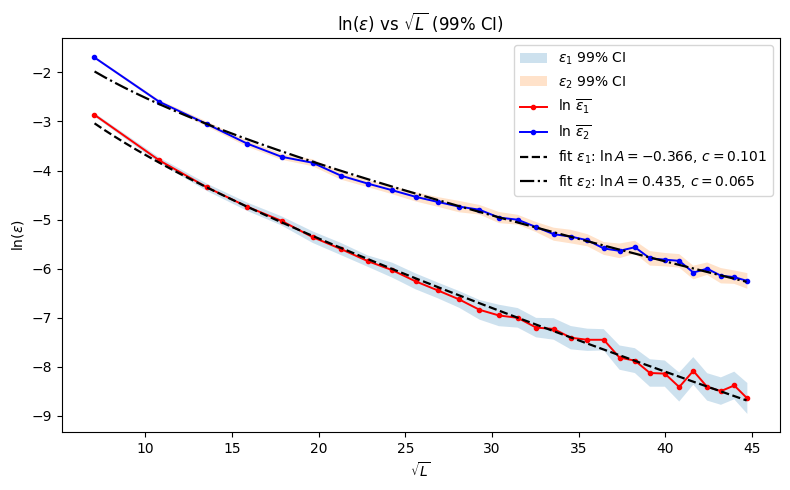

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 用线性回归在 log 空间拟合: ln eps = ln A - c sqrt(L) - 0.5 ln L
def fit_log_with_lnL(L, eps):
    mask = (eps > 0)
    X = np.sqrt(L[mask])
    y = np.log(eps[mask]) + 0.5 * np.log(L[mask])  # move (ln L)/2 to LHS
    m, b = np.polyfit(X, y, deg=1)  # y ~ m*X + b
    c = -m
    A = np.exp(b)
    return A, c

df = pd.read_csv('data/test_result_delta=1e-01.csv')

Lvals = df["L"].values
eps1vals = df["eps1"].values
eps2vals = df["eps2"].values

A1, c1 = fit_log_with_lnL(Lvals, eps1vals)
A2, c2 = fit_log_with_lnL(Lvals, eps2vals)

Z99 = 2.576  # 99% z-score

# ---- per-L stats in log space for a given column ----
def log_stats_by_L(df, col, z=Z99):
    out = []
    for L, g in df.groupby("L"):
        vals = g[col].to_numpy()
        vals = vals[vals > 0]
        if len(vals) == 0:
            continue
        logs = np.log(vals)
        mu = logs.mean()
        n = len(logs)
        if n > 1:
            se = logs.std(ddof=1) / np.sqrt(n)
            lo, hi = mu - z*se, mu + z*se
        else:
            se = np.nan
            lo = hi = mu
        out.append((L, np.sqrt(L), mu, lo, hi, n))
    arr = pd.DataFrame(out, columns=["L","x","mu","lo","hi","n"]).sort_values("x")
    return arr

gm1_log = log_stats_by_L(df, "eps1", z=Z99)
gm2_log = log_stats_by_L(df, "eps2", z=Z99)

# ---- combined figure: x = sqrt(L), y = ln(eps) ----
plt.figure(figsize=(8,5))

# 99% CI bands (log-space, additive)
plt.fill_between(gm1_log["x"], gm1_log["lo"], gm1_log["hi"], alpha=0.22, label=r"$\epsilon_1$ 99% CI")
plt.fill_between(gm2_log["x"], gm2_log["lo"], gm2_log["hi"], alpha=0.22, label=r"$\epsilon_2$ 99% CI")

# geometric-mean lines (log-space mean)
plt.plot(gm1_log["x"], gm1_log["mu"], "r-o", ms=3, lw=1.4, label=r"$\ln\,\overline{\epsilon_1}$")
plt.plot(gm2_log["x"], gm2_log["mu"], "b-o", ms=3, lw=1.4, label=r"$\ln\,\overline{\epsilon_2}$")

# fit lines in (x = sqrt L, y = ln eps) coordinates:
# y_fit(x) = ln(A) - c*x - ln(x)
xfit = np.linspace(np.sqrt(np.min(Lvals[Lvals>0]))*1.001, np.sqrt(np.max(Lvals))*0.999, 400)
yfit1 = np.log(A1) - c1*xfit - np.log(xfit)
yfit2 = np.log(A2) - c2*xfit - np.log(xfit)
plt.plot(xfit, yfit1, "k--", lw=1.6, label=fr"fit $\epsilon_1$: $\ln A={np.log(A1):.3g},\, c={c1:.3g}$")
plt.plot(xfit, yfit2, "k-.", lw=1.6, label=fr"fit $\epsilon_2$: $\ln A={np.log(A2):.3g},\, c={c2:.3g}$")

plt.xlabel(r"$\sqrt{L}$")
plt.ylabel(r"$\ln(\epsilon)$")
plt.title(r"$\ln(\epsilon)$ vs $\sqrt{L}$ (99% CI)")
plt.legend()
plt.tight_layout()
plt.show()



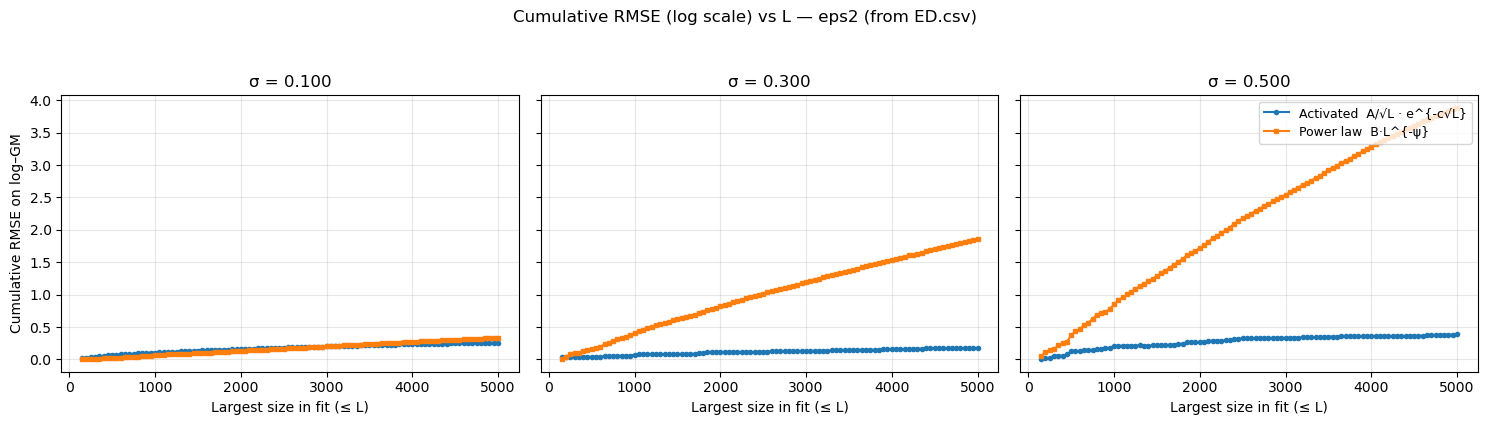


L* table:
 sigma  L_star
  0.10  2950.0
  0.11  1950.0
  0.12  1100.0
  0.13   950.0
  0.14   700.0
  0.15   650.0
  0.16   600.0
  0.17   500.0
  0.18   450.0
  0.19   250.0
  0.20   200.0
  0.21   200.0
  0.22   200.0
  0.23   200.0
  0.24   200.0
  0.25   200.0
  0.26   150.0
  0.27   200.0
  0.28   150.0
  0.29   150.0
  0.30   150.0
  0.31   150.0
  0.32   150.0
  0.33   150.0
  0.34   150.0
  0.35   150.0
  0.36   150.0
  0.37   150.0
  0.38   150.0
  0.39   150.0
  0.40   150.0
  0.41   150.0
  0.42   150.0
  0.43   150.0
  0.44   150.0
  0.45   150.0
  0.46   150.0
  0.47   150.0
  0.48   150.0
  0.49   150.0
  0.50     NaN


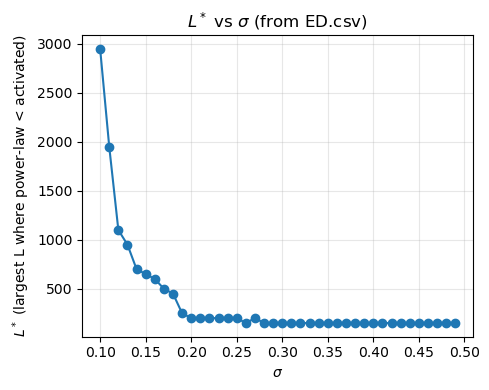

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ========== Helpers ==========
def log_mean_stats(df, col="eps2"):
    """
    Per-L log geometric mean and its standard error (on log scale).
    Returns a tidy table sorted by L with columns: L, mu, se, n
    """
    rows=[]
    for L, g in df.groupby("L"):
        v = g[col].to_numpy()
        v = v[v > 0]
        if v.size == 0:
            continue
        logs = np.log(v)
        n = logs.size
        mu = logs.mean()
        se = logs.std(ddof=1)/np.sqrt(n) if n > 1 else np.nan
        rows.append((float(L), mu, se, n))
    out = pd.DataFrame(rows, columns=["L","mu","se","n"]).sort_values("L").reset_index(drop=True)
    return out

def weights_from_se(se):
    w = np.zeros_like(se, dtype=float)
    finite = np.isfinite(se) & (se > 0)
    if finite.any():
        w[finite] = 1.0/(se[finite]**2)
        medw = np.median(w[finite])
        w[~finite] = medw
    else:
        w[:] = 1.0
    return w

# Models:
# Activated: GM ≈ A/√L * exp(-c√L)  -> mu = lnA - c√L - 0.5 ln L
def fit_activated(L, mu, w=None):
    X = np.sqrt(L)
    y = mu + 0.5*np.log(L)
    if w is None:
        b, a = np.polyfit(X, y, 1)
    else:
        b, a = np.polyfit(X, y, 1, w=w)
    lnA, c = a, -b
    return lnA, c

def pred_activated(L, lnA, c):
    return lnA - c*np.sqrt(L) - 0.5*np.log(L)

# Power law: GM ≈ B * L^{-ψ}  -> mu = lnB - ψ ln L
def fit_powerlaw(L, mu, w=None):
    X = np.log(L)
    y = mu
    if w is None:
        b, a = np.polyfit(X, y, 1)
    else:
        b, a = np.polyfit(X, y, 1, w=w)
    lnB, psi = a, -b
    return lnB, psi

def pred_powerlaw(L, lnB, psi):
    return lnB - psi*np.log(L)

# Errors
def rmse_log(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def wrmse_log(y, yhat, w):
    return np.sqrt(np.sum(w*(y - yhat)**2) / np.sum(w))

# Cumulative learning curves (fits using all L' ≤ current L)
def cumulative_curves(L, mu, se, min_pts=3, use_weights=True):
    order = np.argsort(L)
    Ls, mus, ses = L[order], mu[order], se[order]

    cum_L, err_act, err_pow = [], [], []
    for k in range(min_pts, len(Ls)+1):
        L_train, mu_train, se_train = Ls[:k], mus[:k], ses[:k]
        if use_weights:
            w = weights_from_se(se_train)
            lnA, c   = fit_activated(L_train, mu_train, w=w)
            lnB, psi = fit_powerlaw(L_train,  mu_train, w=w)
            e_act = wrmse_log(mu_train, pred_activated(L_train, lnA, c), w)
            e_pow = wrmse_log(mu_train, pred_powerlaw(L_train, lnB, psi), w)
        else:
            lnA, c   = fit_activated(L_train, mu_train, w=None)
            lnB, psi = fit_powerlaw(L_train,  mu_train, w=None)
            e_act = rmse_log(mu_train, pred_activated(L_train, lnA, c))
            e_pow = rmse_log(mu_train, pred_powerlaw(L_train, lnB, psi))
        cum_L.append(L_train[-1]); err_act.append(e_act); err_pow.append(e_pow)

    return pd.DataFrame({
        "L": np.array(cum_L),
        "RMSE_activated_log": np.array(err_act),
        "RMSE_powerlaw_log":  np.array(err_pow)
    })

def compute_cum_curves_for_sigma(big_df, sigma, min_pts=3, use_weights=True):
    sdf = big_df.loc[big_df["sigma"] == sigma, ["L", "eps2"]].copy()
    if sdf.empty:
        return None
    # ensure integer L (in case of float)
    sdf["L"] = sdf["L"].astype(int)
    tbl = log_mean_stats(sdf, "eps2")
    if len(tbl) < min_pts:
        return None
    L, mu, se = tbl["L"].to_numpy(), tbl["mu"].to_numpy(), tbl["se"].to_numpy()
    return cumulative_curves(L, mu, se, min_pts=min_pts, use_weights=use_weights)

def compute_L_star_for_sigma(big_df, sigma, min_pts=3, use_weights=True):
    curves = compute_cum_curves_for_sigma(big_df, sigma, min_pts=min_pts, use_weights=use_weights)
    if curves is None or curves.empty:
        return np.nan
    better = curves["RMSE_powerlaw_log"] < curves["RMSE_activated_log"]
    return float(curves.loc[better, "L"].max()) if better.any() else np.nan

# ========== Load the consolidated file ==========
path = Path("data/ED.csv")
if not path.exists():
    raise FileNotFoundError("data/ED.csv not found. Make sure you've run the generator script.")

df = pd.read_csv(path)
# Light clean-up
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["sigma", "L", "eps2"])
df["sigma"] = df["sigma"].astype(float)

# ========== 1×3 Cumulative RMSE panels for three representative sigmas ==========
# Pick min, median, max σ present in the file (robust to your actual grid)
sigmas_unique = np.sort(df["sigma"].unique())
if len(sigmas_unique) >= 3:
    idx_mid = len(sigmas_unique)//2
    sigmas_to_plot = [sigmas_unique[0], sigmas_unique[idx_mid], sigmas_unique[-1]]
else:
    # If fewer than 3, just use whatever is available and handle gracefully
    sigmas_to_plot = list(sigmas_unique)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
# If fewer than 3, we still create 3 axes and blank the extras
for i in range(3):
    ax = axes[i]
    if i < len(sigmas_to_plot):
        s = sigmas_to_plot[i]
        curves = compute_cum_curves_for_sigma(df, s, min_pts=3, use_weights=True)
        if curves is None or curves.empty:
            ax.text(0.5, 0.5, f"Insufficient data\nσ={s:.3f}", ha="center", va="center")
            ax.set_axis_off()
            continue
        ax.plot(curves["L"], curves["RMSE_activated_log"], marker="o", ms=3, label="Activated  A/√L · e^{-c√L}")
        ax.plot(curves["L"], curves["RMSE_powerlaw_log"],  marker="s", ms=3, label="Power law  B·L^{-ψ}")
        ax.set_title(f"σ = {s:.3f}")
        ax.set_xlabel("Largest size in fit (≤ L)")
        ax.grid(True, alpha=0.3)
    else:
        ax.set_axis_off()

axes[0].set_ylabel("Cumulative RMSE on log–GM")
# Show legend only once (on the last populated axis)
if len(sigmas_to_plot) > 0:
    axes[min(len(sigmas_to_plot)-1, 2)].legend(loc="upper right", fontsize=9)
fig.suptitle("Cumulative RMSE (log scale) vs L — eps2 (from ED.csv)", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()

# ========== L* vs sigma across ALL sigmas ==========
rows = []
for s in sigmas_unique:
    L_star = compute_L_star_for_sigma(df, s, min_pts=3, use_weights=True)
    rows.append((s, L_star))
res = pd.DataFrame(rows, columns=["sigma","L_star"]).sort_values("sigma").reset_index(drop=True)

print("\nL* table:")
print(res.to_string(index=False))

plt.figure(figsize=(5,4))
plt.plot(res["sigma"], res["L_star"], marker="o")
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$L^*$ (largest L where power-law < activated)")
plt.title(r"$L^*$ vs $\sigma$ (from ED.csv)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
